## Machine Learning Project 2

## Import Packages

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import seaborn as sns

## Load Data

In [4]:
data = pd.read_csv('/Users/jaxen1/Shared/C/Machine Learning/project2/project_adult.csv')
validation = pd.read_csv('/Users/jaxen1/Shared/C/Machine Learning/project2/project_validation_inputs.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jaxen1/Shared/C/Machine Learning/project2/project_adult.csv'

In [5]:
data = pd.read_csv('project_adult.csv')
validation = pd.read_csv('project_validation_inputs.csv')
print(data.head())

   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0     

## Data Preprocessing

In [6]:
# Function to preprocess data
def preprocess_data(df):
    # Take out educational since is ordinal, ordinal var is already in dataset
    df = df.drop(columns = ['Unnamed: 0', 'education'])
    # Replace '?' with NaN for consistancy 
    df = df.replace('?', np.nan)

    # Impute missing values for categorical variables
    categorical_cols = df.select_dtypes(include='object').columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    # Impute missing values for numerical variables
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())



    # TRY EXCEPT SO VALIDATION SET CAN PASS
    # Binarize the target variable
    try:
        df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
    except:
        pass

    # keep track of rows indexes to connect X and y
    df = df.reset_index()

    # Deal with Categorical Values

    # initialize encoder
    encoder = OneHotEncoder(sparse_output=False)
    # pull categorical cols
    categorical_cols = df.select_dtypes(include='object').columns
    # create encoded array w one hot columns
    encoded_array = encoder.fit_transform(df[categorical_cols])
    # Get new column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    # Creae new df of encoded columns
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)
    # Drop the original cat cols, add the one hot encoded one
    df = df.drop(categorical_cols, axis=1)
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop('index', axis = 1)

    # Ensure all columns are numeric after one-hot encoding
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # TRY EXCEPTS SO THE VALIDATION SET CAN PASS WITH NO Y VARIABLE
    # Separate features and target
    try:
        X = df.drop(columns=['income'], axis=1)
    except:
        X = df
    try:
        y = df['income']
    except:
        y = None

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','capital-gain','capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    # Ensure numeric columns exist before scaling
    numeric_cols_exist = [col for col in numeric_cols if col in X.columns]
    if numeric_cols_exist:
        X[numeric_cols_exist] = scaler.fit_transform(X[numeric_cols_exist])


    return X, y

In [7]:
# Run function on both datasets
X, y = preprocess_data(data)
X_validation, _ = preprocess_data(validation)
# Ensure validation set has same columns as training set and in right order
missing_cols = [
    'native-country_Holand-Netherlands',
    'native-country_Outlying-US(Guam-USVI-etc)',
    'workclass_Never-worked'
]
for col in missing_cols:
    X_validation[col] = 0
X_validation = X_validation.reindex(columns=X.columns, fill_value=0)
# Split the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


## Create Simple MLP class function

In [8]:
# Create class for MLP
class SimpleMLP:

    def __init__(self, num_features, num_hidden, num_classes, activation, random_seed=17):
        super().__init__()
        # Define number of classes and activation function type
        self.num_classes = num_classes
        self.activation_name = activation
        
        # Create random weights and biases
        rng = np.random.RandomState(random_seed)

        # Hidden Layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        # Hidden Layer Bias
        self.bias_h = np.zeros(num_hidden)

        # Output Layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        # Output Layer Bias`
        self.bias_out = np.zeros(num_classes)
    
    """
    USE DIFFERENT ACTIVATION FUNCTIONS

    COMPARE:
    IDENTITY
    SIGMOID
    RELU
    TANH
    """
    
    def activation(self, X, activation=None):
        if activation is None:
            activation = self.activation_name
        if activation == "sigmoid":
            return 1 / (1 + np.exp(-X))
        elif activation == "relu":
            return np.maximum(0, X)
        elif activation == "tanh":
            return np.tanh(X)
        elif activation == "identity":
            return X
        else:
            return X
    
    # Make function for activation derivative so can calculate gradients
    def activation_derivative(self, X, activation=None):
        if activation is None:
            activation = self.activation_name
        if activation == "sigmoid":
            sig = self.activation(X, activation)
            return sig * (1 - sig)
        elif activation == "relu":
            return (X > 0).astype(float)
        elif activation == "tanh":
            return 1 - np.tanh(X)**2
        elif activation == "identity":
            return np.ones_like(X)
        else:
            return np.ones_like(X)
    
    # Create function for sigmoid
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    # Forward pass function
    def forward(self, x):
        # Hidden layer
        self.z_h = np.dot(x, self.weight_h.T) + self.bias_h
        self.a_h = self.activation(self.z_h, self.activation_name)
        # Output layer
        self.z_out = np.dot(self.a_h, self.weight_out.T) + self.bias_out
        self.a_out = self.sigmoid(self.z_out) # Since is binary classification, use sigmoid for output layer
        return self.a_h, self.a_out

    # Backward pass function
    def backward(self, x, y_onehot):  

        samples = x.shape[0]
        
        # Output layer gradients
        delta_out = (self.a_out - y_onehot) / samples
        d_weight_out = np.dot(delta_out.T, self.a_h)
        d_bias_out = np.sum(delta_out, axis=0)

        # Hidden layer gradients
        delta_h = np.dot(delta_out, self.weight_out) * self.activation_derivative(self.z_h, self.activation_name)
        d_weight_h = np.dot(delta_h.T, x)
        d_bias_h = np.sum(delta_h, axis=0)

        return (d_weight_out, d_bias_out, d_weight_h, d_bias_h)

### Calculate simple MLP loss

In [9]:
def mse_loss(onehot_targets, probas):
    mse = np.mean((onehot_targets - probas)**2)
    return mse

def cross_entropy_loss(onehot_targets, probas):
    # Clip probabilities to avoid log(0)
    probas = np.clip(probas, 1e-15, 1 - 1e-15)
    ce = -np.mean(np.sum(onehot_targets * np.log(probas) + (1 - onehot_targets) * np.log(1 - probas), axis=1))
    return ce

In [10]:
encoder = OneHotEncoder(sparse_output=False)
y_hot_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_hot_test = encoder.transform(y_test.values.reshape(-1, 1))

### Train Model

In [11]:
def train(model, X_train, X_test, y_onehot_train, y_onehot_test, num_epochs, num_classes, learning_rate=0.01):

    """
    Training Simple MLP modle using entire data set (no train/test split)
    """
  
    epoch_loss_train = []
    epoch_loss_test = []
    
    for e in range(num_epochs):
        print(f"****Epoch: {e}****")

        #### Compute outputs ####
        a_h, a_out = model.forward(X_train)

        #### Compute gradients ####
        d_weight_out, d_bias_out, d_weight_h, d_bias_h = model.backward(X_train, y_onehot_train)

        #### Update weights ####
        model.weight_out -= learning_rate * d_weight_out
        model.bias_out -= learning_rate * d_bias_out
        model.weight_h -= learning_rate * d_weight_h
        model.bias_h -= learning_rate * d_bias_h

        ### Look at test dataset ###
        _, a_out_test = model.forward(X_test)
    
        #### Epoch Logging ####        
        trainLoss = cross_entropy_loss(y_onehot_train, a_out)
        testLoss = cross_entropy_loss(y_onehot_test, a_out_test)
        accuracyTrain = accuracy_score(np.argmax(y_onehot_train, axis=1), np.argmax(a_out, axis=1))
        accuracyTest = accuracy_score(np.argmax(y_onehot_test, axis=1), np.argmax(a_out_test, axis=1))
        epoch_loss_train.append(trainLoss)
        epoch_loss_test.append(testLoss)
        print(f'MSE Train: {trainLoss:.2f}')
        print(f'MSE Test: {testLoss:.2f}')
        print(f'Accuracy Train: {accuracyTrain:.2f}')
        print(f'Accuracy Test: {accuracyTest:.2f}')


    return epoch_loss_train, epoch_loss_test



## mlp pytorch in class

Add stratify from example code for randomness.

In [12]:
# create the train and test set for pytorch
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1, stratify=y)

In [13]:
# normalize data again to numpy torch
X_train_norm = X_train.values.astype(np.float32)
X_test_norm  = X_test.values.astype(np.float32)
X_validation_norm = X_validation.values.astype(np.float32)

In [14]:
# Convert to torch tensors
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train      = torch.from_numpy(y_train.values.astype(np.int64))  # long for NLL/CE
X_test_norm  = torch.from_numpy(X_test_norm).float()
y_test       = torch.from_numpy(y_test.values.astype(np.int64))
X_validation_norm = torch.from_numpy(X_validation_norm).float()

In [15]:
# Create TensorDatasets
train_ds = TensorDataset(X_train_norm, y_train)
test_ds  = TensorDataset(X_test_norm, y_test)   

In [16]:
# Create DataLoaders and set batch size
torch.manual_seed(1)
batch_size = 128        
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size)

### Create Model

In [17]:
import torch.nn as nn
# Create class for MLP
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function):
        super().__init__()
        # DSet the layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

        # Store the activation function module
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'tanh':
            self.activation = nn.Tanh()
        elif activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'identity':
            self.activation = nn.Identity()
        else:
            raise ValueError("Unsupported activation function")
        self.output_activation = nn.Sigmoid()
    # Set forward pass
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.output_activation(self.layer2(x))
        return x


In [18]:
input_size  = X_train_norm.shape[1]
# Since we are using sigmoid at output, use Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()

In [19]:
# Dictionaries to store results per hyperparameter combination
results = {}
loss_hist_dict = {}
accuracy_hist_dict = {}
# Iterating over hyperparameter combinations
# activation functions
for activation_function in ['relu', 'tanh', 'sigmoid', 'identity']:
    # hidden layer sizes
    for hidden_size in [16, 32, 64, 128]:
            # Learning rates
            # Learning rate of 0.001 is too small and 0.1 is too large
            learning_rate = 0.01
            print(f"Activation: {activation_function}, Hidden Size: {hidden_size}")
            model = Model(input_size, hidden_size, 2, activation_function)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            num_epochs = 100
            loss_hist = [0] * num_epochs
            accuracy_hist = [0] * num_epochs
            # Training loop
            for epoch in range(num_epochs):
                for x_batch, y_batch in train_dl:
                    pred = model(x_batch)                             
                    loss = loss_fn(pred, y_batch.long())
                    # Backpropagation
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    loss_hist[epoch] += loss.item()*y_batch.size(0)
                    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                    accuracy_hist[epoch] += is_correct.sum()

                loss_hist[epoch] /= len(train_dl.dataset)
                accuracy_hist[epoch] /= len(train_dl.dataset)
            final_loss = round(float(loss_hist[epoch]),3)
            final_accuracy = round(float(accuracy_hist[epoch]*100),2)
        
            # store stats for this configuration
            key = f'activation: {activation_function}, hidden: {hidden_size}'
            results[key] = {
                'final_loss': final_loss,
                'final_accuracy': final_accuracy
            }
            # Make these dictoinaries of lists to plot later
            loss_hist_dict[key] = [round(float(x), 2) for x in loss_hist]
            accuracy_hist_dict[key] = [round(float(x)*100,2) for x in accuracy_hist]


Activation: relu, Hidden Size: 16
Activation: relu, Hidden Size: 32
Activation: relu, Hidden Size: 64
Activation: relu, Hidden Size: 128
Activation: tanh, Hidden Size: 16
Activation: tanh, Hidden Size: 32
Activation: tanh, Hidden Size: 64
Activation: tanh, Hidden Size: 128
Activation: sigmoid, Hidden Size: 16
Activation: sigmoid, Hidden Size: 32
Activation: sigmoid, Hidden Size: 64
Activation: sigmoid, Hidden Size: 128
Activation: identity, Hidden Size: 16
Activation: identity, Hidden Size: 32
Activation: identity, Hidden Size: 64
Activation: identity, Hidden Size: 128


In [20]:
results_df = pd.DataFrame.from_dict(results, orient='index')

In [21]:
# Finding best accuracy and lowest loss configurations
best_accuracy = max(results.items(), key=lambda x: x[1]['final_accuracy'])
lowest_loss = min(results.items(), key=lambda x: x[1]['final_loss'])

In [22]:
print(f'The best accuracy is {best_accuracy}, the lowest loss is {lowest_loss}')

The best accuracy is ('activation: tanh, hidden: 128', {'final_loss': 0.401, 'final_accuracy': 90.83}), the lowest loss is ('activation: tanh, hidden: 128', {'final_loss': 0.401, 'final_accuracy': 90.83})


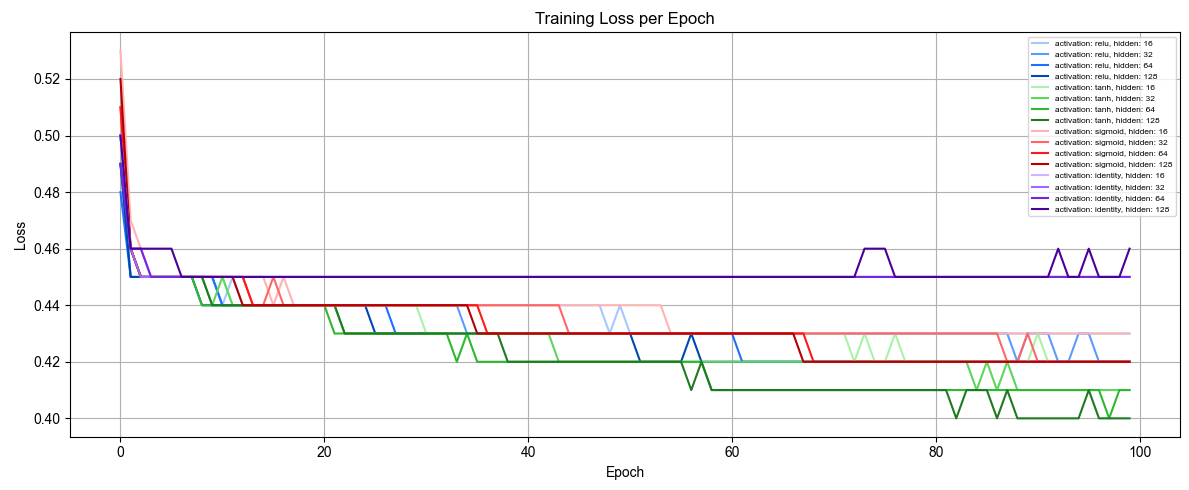

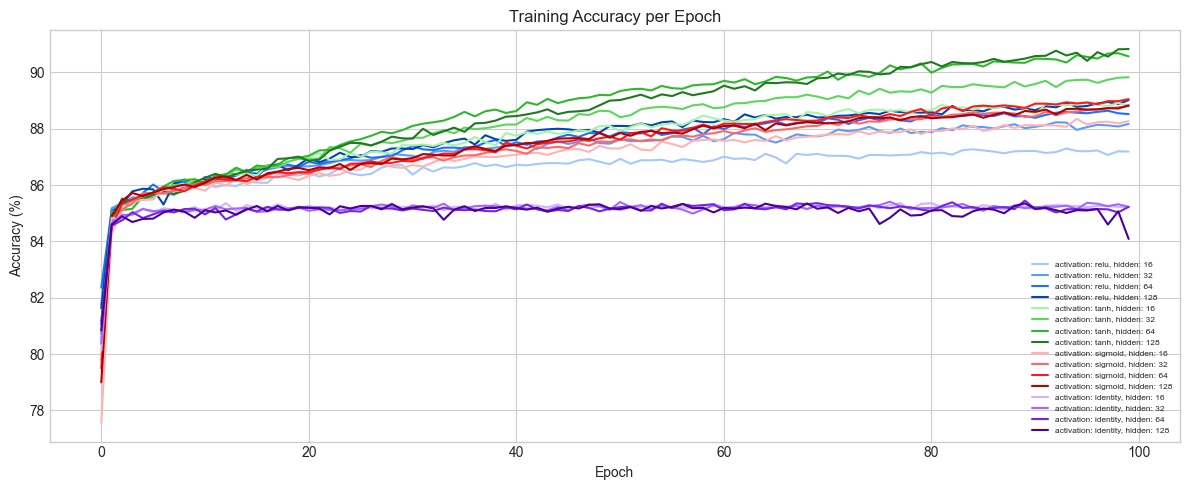

In [23]:
# 4 groups (ReLU, tanh, sigmoid, identity) × 4 shades each
colors = [
    # Blues (ReLU)
    '#a6c8ff', '#5b9bff', '#1f6fff', '#0047b3',
    # Greens (tanh)
    '#a7f3a7', '#5cd65c', '#2eb82e', '#1f7a1f',
    # Reds (sigmoid)
    '#ffb3b3', '#ff6666', '#ff1a1a', '#b30000',
    # Purples (identity)
    '#d1b3ff', '#a366ff', '#7326e6', '#4b0099'
]


## Create plots for loss and accuracy histories
plt.figure(figsize=(12, 5))

for idx, (key, loss_hist) in enumerate(loss_hist_dict.items()):
    plt.plot(loss_hist, label=key, color=colors[idx])

plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=6)
plt.grid(True)
plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.show()

## ^^ not as useful, does not show as much variation between activation functions


plt.figure(figsize=(12, 5))

for idx, (key, acc_hist) in enumerate(accuracy_hist_dict.items()):
    plt.plot(acc_hist, label=key, color=colors[idx])

plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(fontsize=6)
plt.grid(True)
plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.show()

## ^^ More useful, shows variation between models


In [24]:
""" DO THE SAME THING BUT FOR TEST DATASET NOW """

results_test = {}
loss_hist_dict_test = {}
accuracy_hist_dict_test = {}

for activation_function in ['relu', 'tanh', 'sigmoid', 'identity']:
    for hidden_size in [16, 32, 64, 128]:
        learning_rate = 0.01
        print(f"Activation: {activation_function}, Hidden Size: {hidden_size}")
        
        # Train model first
        model = Model(input_size, hidden_size, 2, activation_function)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        num_epochs = 100
        for epoch in range(num_epochs):
            for x_batch, y_batch in train_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch.long())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        # Evaluate on TEST data (no gradients!)
        model.eval()
        loss_hist = [0] * num_epochs
        accuracy_hist = [0] * num_epochs
        with torch.no_grad():
            for epoch in range(num_epochs):
                total_loss, total_correct = 0, 0
                total_samples = 0
                for x_batch, y_batch in test_dl:
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch.long())
                    total_loss += loss.item() * y_batch.size(0)
                    total_correct += (torch.argmax(pred, dim=1) == y_batch).sum().item()
                    total_samples += y_batch.size(0)
                loss_hist[epoch] = total_loss / total_samples
                accuracy_hist[epoch] = total_correct / total_samples

        final_loss = round(float(loss_hist[-1]), 3)
        final_accuracy = round(float(accuracy_hist[-1] * 100), 2)

        key = f'activation: {activation_function}, hidden: {hidden_size}'
        results_test[key] = {
            'final_loss': final_loss,
            'final_accuracy': final_accuracy
        }
        loss_hist_dict_test[key] = [round(float(x), 2) for x in loss_hist]
        accuracy_hist_dict_test[key] = [round(float(x) * 100, 2) for x in accuracy_hist]


Activation: relu, Hidden Size: 16
Activation: relu, Hidden Size: 32
Activation: relu, Hidden Size: 64
Activation: relu, Hidden Size: 128
Activation: tanh, Hidden Size: 16
Activation: tanh, Hidden Size: 32
Activation: tanh, Hidden Size: 64
Activation: tanh, Hidden Size: 128
Activation: sigmoid, Hidden Size: 16
Activation: sigmoid, Hidden Size: 32
Activation: sigmoid, Hidden Size: 64
Activation: sigmoid, Hidden Size: 128
Activation: identity, Hidden Size: 16
Activation: identity, Hidden Size: 32
Activation: identity, Hidden Size: 64
Activation: identity, Hidden Size: 128


In [25]:
# Create DataFrame for test results
results_test_df = pd.DataFrame.from_dict(results_test, orient='index')
results_test_df['activation'] = ['ReLU']*4 + ['tanh']*4 + ['sigmoid']*4 + ['identity']*4
results_test_df['hidden_size'] =[str(16), str(32), str(64), str(128)]*4

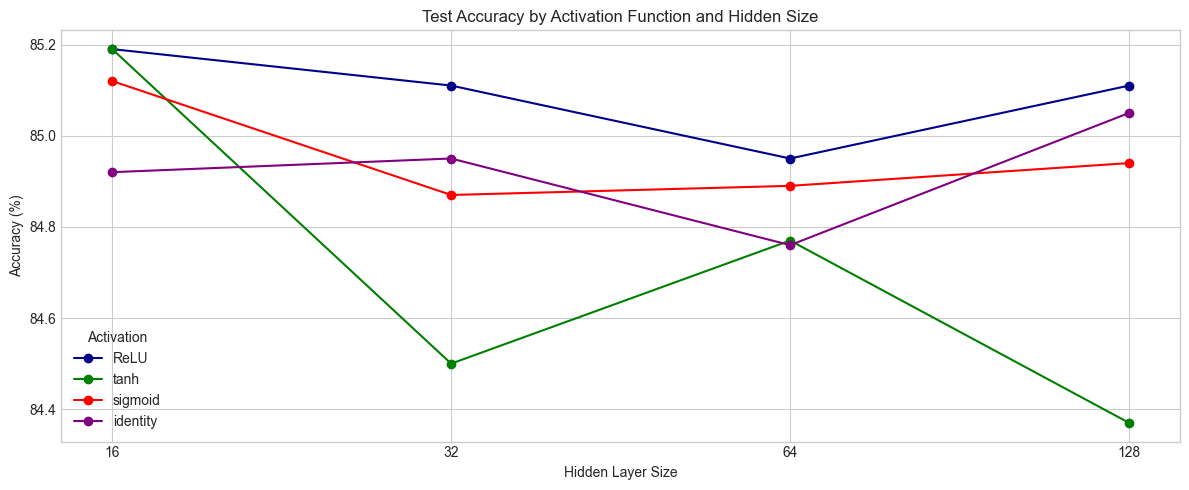

In [26]:
# Plot accuracy for test data
plt.figure(figsize=(12, 5))
colors = ['darkblue', 'green', 'red', 'purple']
for color, activation in zip(colors, results_test_df["activation"].unique()):
    subset = results_test_df[results_test_df["activation"] == activation]
    plt.plot(subset["hidden_size"], subset["final_accuracy"], marker="o", label=activation, color = color)

plt.title("Test Accuracy by Activation Function and Hidden Size")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Accuracy (%)")
plt.legend(title="Activation")
plt.grid(True)
plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.show()

ReLU: Performed better on testing data

tanh: Overfit the training data a bit, worse than identity

sigmoid: not as good generalization

identity: too simple

The difference in accuracies is not really significant enough, pick the simpler model and avoid overfitting

In [27]:
# Train model first
## Best model from previous tests was ReLU with 16 hidden units
test_model = Model(input_size, 16, 2, 'relu')
optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
num_epochs = 1001 #1001 because 0 indexing messes with logging every 100 epochs
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
test_acc = pd.DataFrame(columns=['Epoch', 'Test Loss', 'Test Accuracy'])
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = test_model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    test_loss = round(float(loss_hist[epoch]),3)
    test_accuracy = round(float(accuracy_hist[epoch]*100),2)
    if epoch % 100 == 0:
        pred_test = test_model(X_test_norm)
        correct = (torch.argmax(pred_test, dim=1) == y_test).float()
        accuracy = correct.mean()
        loss = loss_fn(pred_test, y_test.long())
        test_acc.loc[len(test_acc)] = {
    'Epoch': epoch,
    'Test Loss': round(loss.item(), 3),
    'Test Accuracy': round(float(accuracy * 100), 2)
}
        print(f"Epoch {epoch}: Train Loss: {round(loss.item(), 3)}, Train Accuracy: {round(float(accuracy * 100), 2)}%")

Epoch 0: Train Loss: 0.458, Train Accuracy: 84.58%
Epoch 100: Train Loss: 0.455, Train Accuracy: 85.01%
Epoch 200: Train Loss: 0.456, Train Accuracy: 85.17%
Epoch 300: Train Loss: 0.456, Train Accuracy: 85.13%
Epoch 400: Train Loss: 0.458, Train Accuracy: 85.01%
Epoch 500: Train Loss: 0.458, Train Accuracy: 84.95%
Epoch 600: Train Loss: 0.457, Train Accuracy: 85.11%
Epoch 700: Train Loss: 0.458, Train Accuracy: 84.96%
Epoch 800: Train Loss: 0.457, Train Accuracy: 85.02%
Epoch 900: Train Loss: 0.458, Train Accuracy: 84.89%
Epoch 1000: Train Loss: 0.458, Train Accuracy: 85.12%


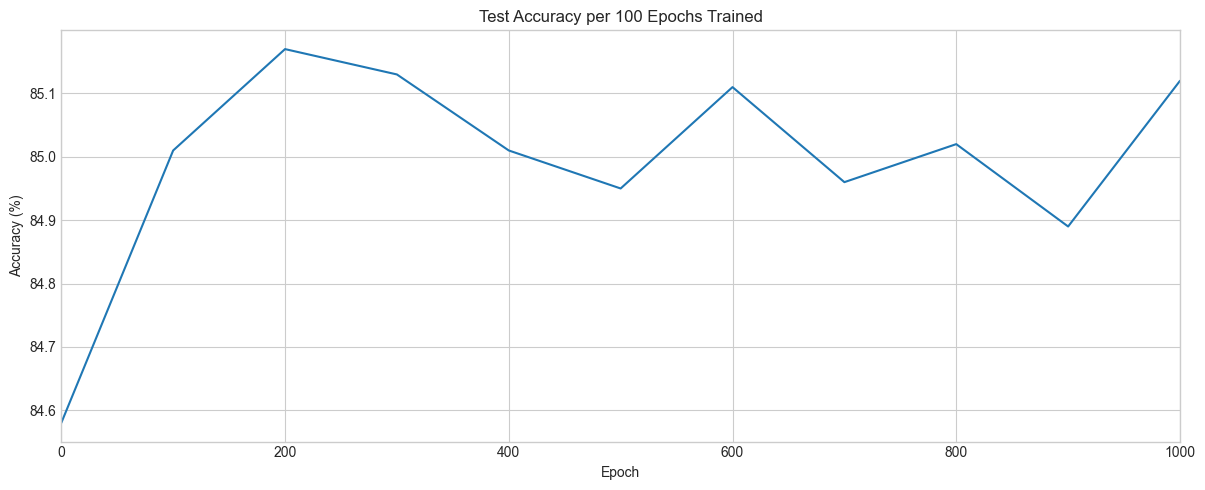

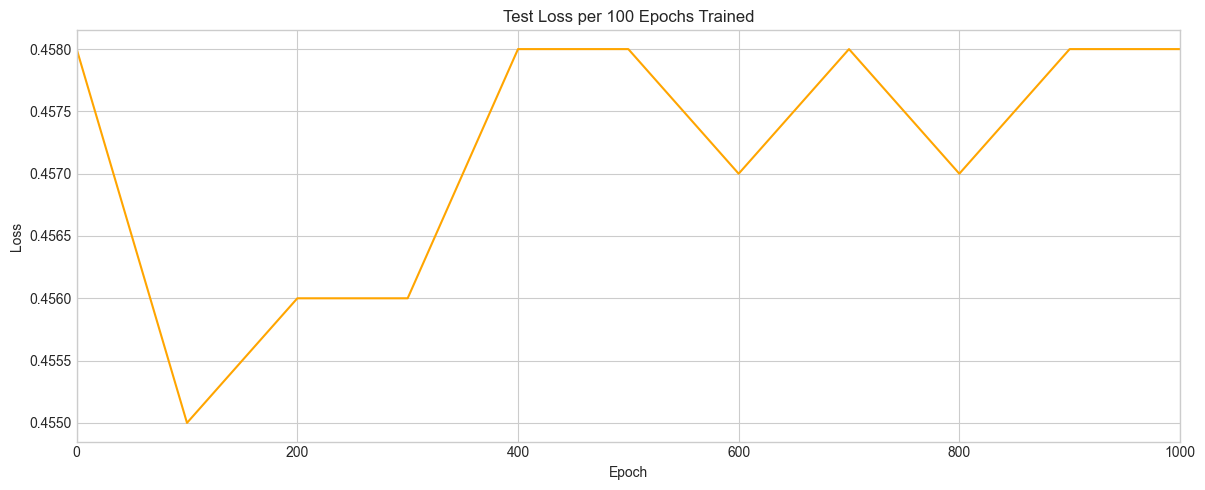

In [28]:
# LOOK AT MODELS ON TESTING DATA
plt.figure(figsize=(12, 5))
plt.plot(test_acc['Epoch'], test_acc['Test Accuracy'], label='Test Accuracy')
plt.title("Test Accuracy per 100 Epochs Trained")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.xlim(0, 1000)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(test_acc['Epoch'], test_acc['Test Loss'], label='Test Loss', color = 'orange')
plt.title("Test Loss per 100 Epochs Trained")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.xlim(0, 1000)
plt.show()

In [29]:
# Train model first
best_model = Model(input_size, 16, 2, 'relu')
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.01)
num_epochs = 101
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(0, num_epochs):
    for x_batch, y_batch in train_dl:
        pred = best_model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)
    best_loss = round(float(loss_hist[epoch]),3)
    best_accuracy = round(float(accuracy_hist[epoch]*100),2)

/var/folders/_y/r2dpgnhs1h38x5_cq27b9xlw0000gn/T/ipykernel_32381/2686748930.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


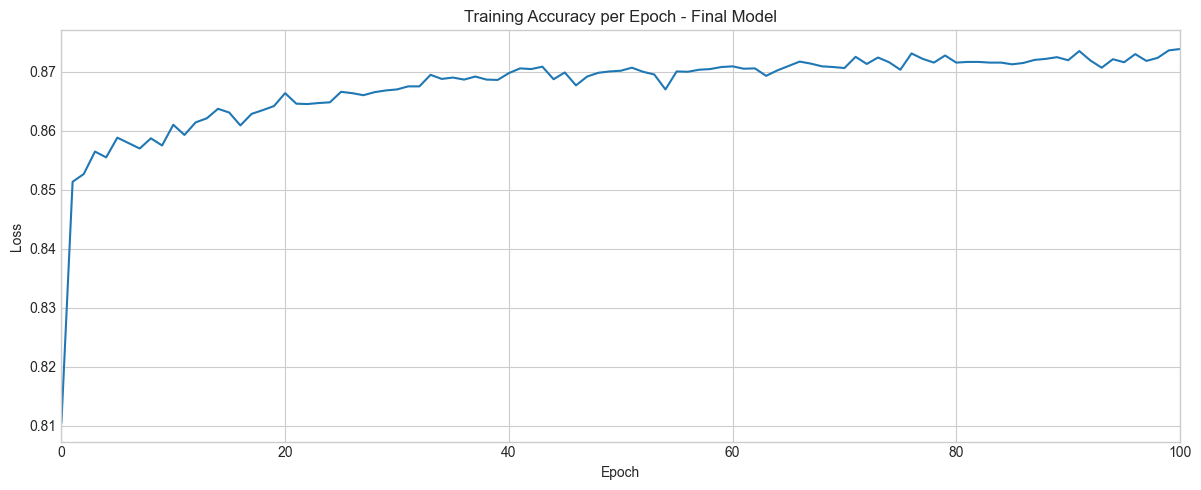

/var/folders/_y/r2dpgnhs1h38x5_cq27b9xlw0000gn/T/ipykernel_32381/2686748930.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


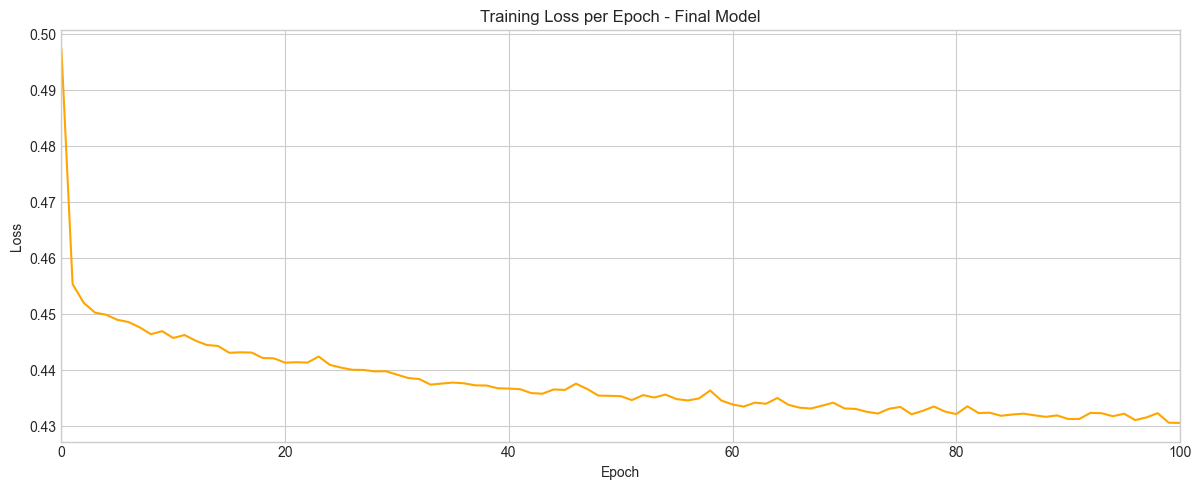

In [30]:
# Plot final model training loss and accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(len(accuracy_hist)), accuracy_hist)
plt.title("Training Accuracy per Epoch - Final Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.show()

# Plot final model training loss
plt.figure(figsize=(12, 5))
plt.plot(loss_hist, color = 'orange')

plt.title("Training Loss per Epoch - Final Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.style.use('seaborn-v0_8-whitegrid')
plt.xlim(0, 100)
plt.show()

In [31]:
# Evaluate on test data
pred_test = best_model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8486


In [32]:
# Save and load the model
path = 'income.pt'
torch.save(best_model, path)
model_new = torch.load(path, weights_only=False)
model_new.eval()

Model(
  (layer1): Linear(in_features=89, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=2, bias=True)
  (activation): ReLU()
  (output_activation): Sigmoid()
)

In [33]:
# Predict validation set and print to csv
pred_val = best_model(X_validation_norm)           
preds_val = torch.argmax(pred_val, dim=1).cpu().numpy()  
preds_final = np.where(preds_val == 1, 1, -1)
predictions = pd.DataFrame({"prediction": preds_final})
predictions.to_csv("Group_9_MLP_PredictedOutputs.csv", index=False)

In [34]:
predictions_test = torch.argmax(pred_test, dim=1)

/var/folders/_y/r2dpgnhs1h38x5_cq27b9xlw0000gn/T/ipykernel_32381/3378554090.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


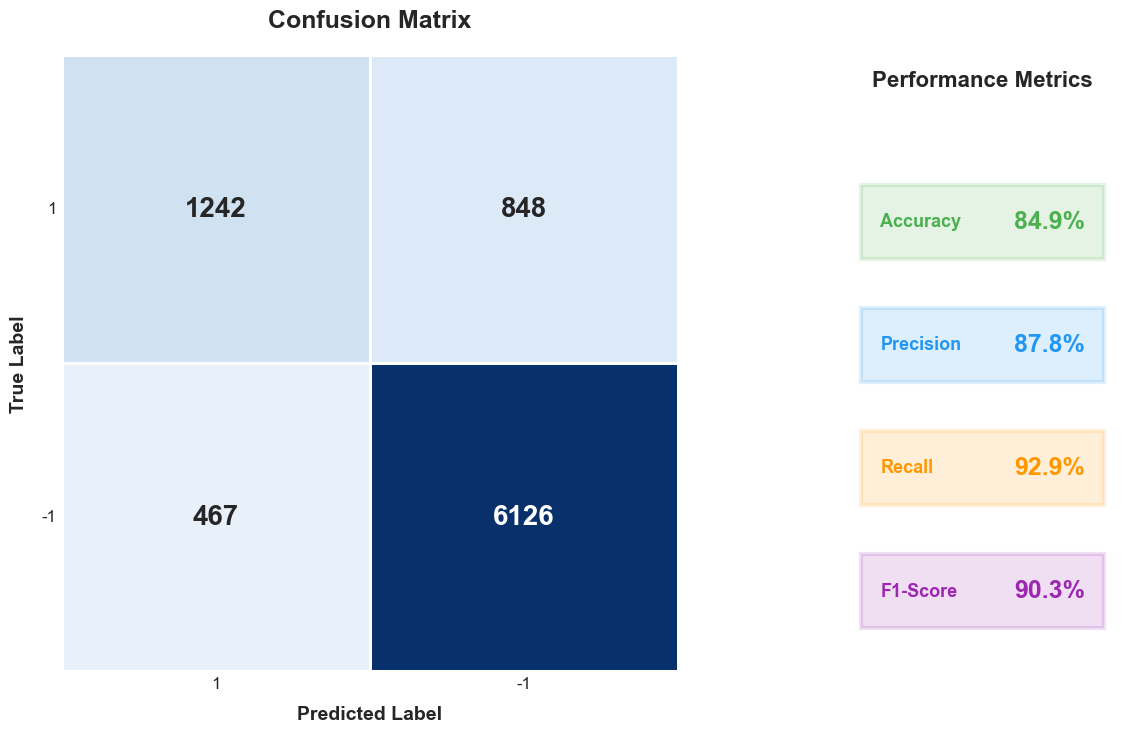

In [35]:
# Compute confusion matrix
cm = confusion_matrix(y_test, predictions_test, labels=[1, 0])

# Create figure with extra space for metrics
fig = plt.figure(figsize=(14, 8), dpi=100)

# Create gridspec for layout
gs = fig.add_gridspec(1, 2, width_ratios=[2.5, 1], wspace=0.3)
ax_heatmap = fig.add_subplot(gs[0])
ax_metrics = fig.add_subplot(gs[1])

# Use seaborn for prettier heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            square=True, linewidths=2, linecolor='white',
            cbar=False,
            cbar_kws={'shrink': 0.8, 'label': 'Count'},
            annot_kws={'size': 20, 'weight': 'bold'},
            vmin=0, ax=ax_heatmap)

# Customize labels
ax_heatmap.set_xlabel('Predicted Label', fontsize=14, fontweight='bold', labelpad=10)
ax_heatmap.set_ylabel('True Label', fontsize=14, fontweight='bold', labelpad=10)
ax_heatmap.set_title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)

# Set tick labels
ax_heatmap.set_xticklabels([1, -1], fontsize=12, rotation=0)
ax_heatmap.set_yticklabels([1, -1], fontsize=12, rotation=0)

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Turn off axes for metrics panel
ax_metrics.axis('off')

# Add title for metrics
ax_metrics.text(0.5, 0.95, 'Performance Metrics', 
                fontsize=16, fontweight='bold', ha='center',
                transform=ax_metrics.transAxes)

# Create metrics display with individual colored boxes
metrics = [
    ('Accuracy', accuracy, '#4CAF50'),
    ('Precision', precision, '#2196F3'),
    ('Recall', recall, '#FF9800'),
    ('F1-Score', f1, '#9C27B0')
]

y_positions = [0.75, 0.55, 0.35, 0.15]

for i, ((name, value, color), y_pos) in enumerate(zip(metrics, y_positions)):
    # Create background rectangle
    rect = plt.Rectangle((0.05, y_pos - 0.08), 0.9, 0.12, 
                         transform=ax_metrics.transAxes,
                         facecolor=color, alpha=0.15, 
                         edgecolor=color, linewidth=3,
                         zorder=10, clip_on=False)
    ax_metrics.add_patch(rect)
    
    # Add metric name
    ax_metrics.text(0.12, y_pos - 0.02, name, 
                   transform=ax_metrics.transAxes, 
                   fontsize=13, fontweight='bold', color=color,
                   verticalalignment='center', zorder=11)
    
    # Add metric value (larger and bolder)
    ax_metrics.text(0.88, y_pos - 0.02, f'{value*100:.1f}%', 
                   transform=ax_metrics.transAxes, 
                   fontsize=18, fontweight='bold', color=color,
                   verticalalignment='center', ha='right', zorder=11)

plt.tight_layout()
plt.show()

## Reflection and Conceptual Questions

### Why did you choose the specific architecture (e.g., number of layers, activation functions) for each model?

### How did you monitor and mitigate overfitting in your models?


### What ethical concerns might arise from deploying models trained on these datasets?

### Why are activation functions necessary in neural networks?